# Final Projection: Opinion Spam Detection

TCSS 535

Name: Jin Young Park

Student ID number: 1971490

In [ ]:
from google.colab import drive
import os
import fnmatch
import pandas as pd
import regex as re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import time

## 1. File Upload

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/TCSS_535_FinalProject/op_spam_v1.4'

In [ ]:
config_files = [os.path.join(subdir,f)
for subdir, dirs, files in os.walk(path)
    for f in fnmatch.filter(files, '*.txt')]

In [ ]:
truth_or_deceptive = []
for f in config_files:
    c = re.search('(trut|deceptiv)\w',f)
    truth_or_deceptive.append(c.group())
labels_ToD = pd.DataFrame(truth_or_deceptive, columns = ['Labels'])

In [ ]:
polarity = []
for f in config_files:
    c = re.search('(positiv|negativ)\w',f)
    polarity.append(c.group())
polarities = pd.DataFrame(polarity, columns = ['Polarity'])

In [ ]:
source = []
for f in config_files:
    c = re.search('(MTur|TripAdviso|We)\w',f)
    source.append(c.group())
sources = pd.DataFrame(source, columns = ['Source'])

In [ ]:
hotel = []
for f in config_files:
    c = re.search('(affini|allegr|amalf|ambassado|conra|fairmon|hardroc|hilto|homewoo|hyat|intercontinenta|jame|knickerbocke|monac|omn|palme|sherato|sofite|swissote|talbot)\w',f)
    hotel.append(c.group())
hotels = pd.DataFrame(hotel, columns = ['Hotel'])

In [ ]:
review = []
directory =os.path.join("/content/drive/My Drive/TCSS_535_FinalProject/op_spam_v1.4")
for subdir,dirs ,files in os.walk(directory):
    for file in files:
        if fnmatch.filter(files, '*.txt'):
            f=open(os.path.join(subdir, file),'r')
            a = f.read()
            review.append(a)
reviews = pd.DataFrame(review, columns = ['Reviews'])

In [ ]:
hotelreview_df= pd.merge(reviews, polarities,right_index=True,left_index = True)
hotelreview_df= pd.merge(hotelreview_df, sources,right_index=True,left_index = True)
hotelreview_df= pd.merge(hotelreview_df, hotels,right_index=True,left_index = True)
hotelreview_df= pd.merge(hotelreview_df, labels_ToD,right_index=True,left_index = True)
hotelreview_df.head()

,Reviews,Polarity,Source,Hotel,Labels
0,James Chicago; the luxurious nice hotel as it ...,negative,MTurk,james,deceptive
1,The James Hotel in Chicago looks nice on the w...,negative,MTurk,james,deceptive
2,I was consistently disappointed throughout my ...,negative,MTurk,james,deceptive
3,Traveled to this hotel on a family vacation. W...,negative,MTurk,monaco,deceptive
4,The staff at the James Chicago hotel seemed de...,negative,MTurk,james,deceptive


## 2. Analyze the given data set

In [ ]:
hotelreview_df.shape

(1600, 5)

In [ ]:
hotelreview_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Reviews   1600 non-null   object
 1   Polarity  1600 non-null   object
 2   Source    1600 non-null   object
 3   Hotel     1600 non-null   object
 4   Labels    1600 non-null   object
dtypes: object(5)
memory usage: 62.6+ KB


In [ ]:
hotelreview_df.isnull().sum()

Reviews     0
Polarity    0
Source      0
Hotel       0
Labels      0
dtype: int64

In [ ]:
hotelreview_df.describe()

,Reviews,Polarity,Source,Hotel,Labels
count,1600,1600,1600,1600,1600
unique,1596,2,3,20,2
top,Very disappointed in our stay in Chicago Monoc...,negative,MTurk,affinia,truth
freq,2,800,800,80,800


In [ ]:
hotelreview_df.Labels.value_counts()

truth        800
deceptive    800
Name: Labels, dtype: int64

In [ ]:
hotelreview_df.Source.value_counts()

MTurk          800
TripAdvisor    400
Web            400
Name: Source, dtype: int64

In [ ]:
hotelreview_df.Polarity.value_counts()

negative    800
positive    800
Name: Polarity, dtype: int64

In [ ]:
hotelreview_df.Hotel.value_counts()

affinia             80
knickerbocker       80
fairmont            80
homewood            80
swissotel           80
monaco              80
james               80
palmer              80
hardrock            80
allegro             80
talbott             80
sofitel             80
conrad              80
hilton              80
amalfi              80
sheraton            80
omni                80
hyatt               80
intercontinental    80
ambassador          80
Name: Hotel, dtype: int64

## 3. Compute Statistic / Visualization

In [ ]:
hotelreview_df[800:1200]

,Reviews,Polarity,Source,Hotel,Labels
800,The staff recognizes you by name with excellen...,positive,TripAdvisor,ambassador,truth
801,I checked in at the Affinia Hotel in Chicago s...,positive,TripAdvisor,affinia,truth
802,My stay at the Ambassador East was great! The ...,positive,TripAdvisor,ambassador,truth
803,Stayed at the Talbott for over a week and enjo...,positive,TripAdvisor,talbott,truth
804,Stayed here for 4 nights in Apri. From check i...,positive,TripAdvisor,hardrock,truth
...,...,...,...,...,...
1195,We stayed in a king suite at the Hotel Allegro...,positive,TripAdvisor,allegro,truth
1196,"Guys trip to Chicago, scored this hotel on Pri...",positive,TripAdvisor,palmer,truth
1197,We recently stayed at the Intercontinental Hot...,positive,TripAdvisor,intercontinental,truth
1198,"I am a fan of Kimpton Hotels, however I have n...",positive,TripAdvisor,allegro,truth


In [ ]:
hotelreview_df.Reviews[0:400]

0      James Chicago; the luxurious nice hotel as it ...
1      The James Hotel in Chicago looks nice on the w...
2      I was consistently disappointed throughout my ...
3      Traveled to this hotel on a family vacation. W...
4      The staff at the James Chicago hotel seemed de...
                             ...                        
395    After a one night stay at the Millennium Knick...
396    I stayed in the Homewood Suites in downtown Ch...
397    I recently stayed at the Swissotel Chicago wit...
398    I booked my room at the Sheraton Chicago Hotel...
399    I want everyone to know about the awful experi...
Name: Reviews, Length: 400, dtype: object

### Word Cloud

Word Cloud is a visualization technique where the size of each word indicates the frequency or importance of text data.

In [ ]:
stopword_list=[]
def displayWordCloud(data = None, backgroundcolor = 'black', width=800, height=600 ): 
  wordcloud = WordCloud(stopwords= stopword_list, background_color = backgroundcolor, width = width, height = height).generate(data) 
  print(wordcloud.words_) 
  plt.figure(figsize = (15, 10)) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.show()

Negative Deceptive

{'and': 1.0, 'but': 0.33745874587458746, 'that': 0.3234323432343234, 'the room': 0.3226072607260726, 'in the': 0.31518151815181517, 'at the': 0.3094059405940594, 'for': 0.2871287128712871, 'was': 0.27805280528052806, 'the hotel': 0.25577557755775576, 'of the': 0.2533003300330033, 'in': 0.2103960396039604, 'it': 0.20874587458745875, 'it was': 0.20462046204620463, 'and the': 0.2037953795379538, 'with': 0.1971947194719472, 'me': 0.19389438943894388, 'as': 0.16501650165016502, 'to be': 0.16336633663366337, 'this hotel': 0.15924092409240925, 'when': 0.1551155115511551, 'for the': 0.15181518151815182, 'after': 0.14933993399339934, 'on the': 0.14603960396039603, 'on': 0.14026402640264027, 'so': 0.13613861386138615, 'we were': 0.13448844884488448, 'there was': 0.12788778877887788, 'was not': 0.12623762376237624, 'my room': 0.12128712871287128, 'or': 0.11963696369636964, 'room was': 0.11963696369636964, 'of': 0.11468646864686469, 'front desk': 0.11468646864686469, 'just': 0.11386138613861387, '

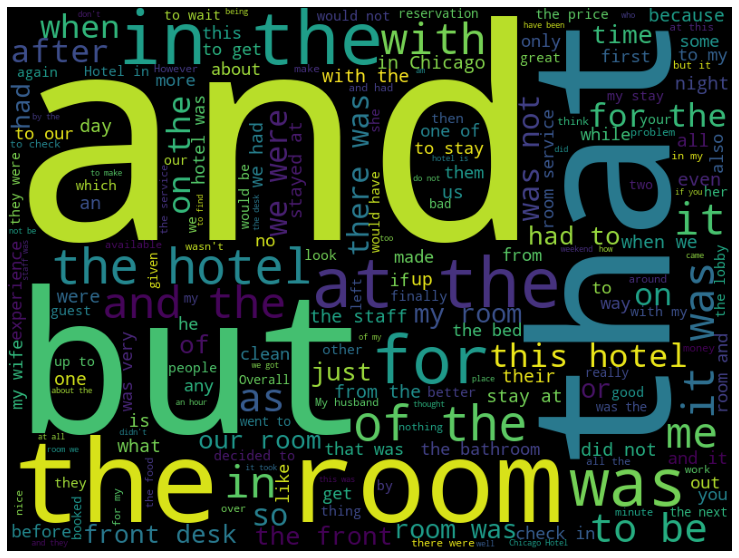

In [ ]:
displayWordCloud(''.join(hotelreview_df.Reviews[0:400]))

Nagative Truth

{'and': 1.0, 'that': 0.26151315789473684, 'it': 0.2571271929824561, 'for': 0.2565789473684211, 'in': 0.24013157894736842, 'but': 0.22478070175438597, 'in the': 0.21929824561403508, 'was': 0.21162280701754385, 'the room': 0.18530701754385964, 'the hotel': 0.17160087719298245, 'with': 0.16392543859649122, 'of the': 0.15789473684210525, 'on': 0.14309210526315788, 'to': 0.1387061403508772, 'the': 0.13322368421052633, 'to the': 0.12609649122807018, 'at the': 0.12171052631578948, 'as': 0.11403508771929824, 'room': 0.1118421052631579, 'had': 0.1112938596491228, 'my': 0.10910087719298246, 'on the': 0.10910087719298246, 'of': 0.10307017543859649, 'hotel': 0.10197368421052631, 'so': 0.09868421052631579, 'it was': 0.09868421052631579, 'or': 0.0981359649122807, 'no': 0.09703947368421052, 'for the': 0.09429824561403509, 'is': 0.09210526315789473, 'me': 0.08991228070175439, 'we were': 0.08991228070175439, 'when': 0.08881578947368421, 'this hotel': 0.08717105263157894, 'were': 0.08114035087719298, 'j

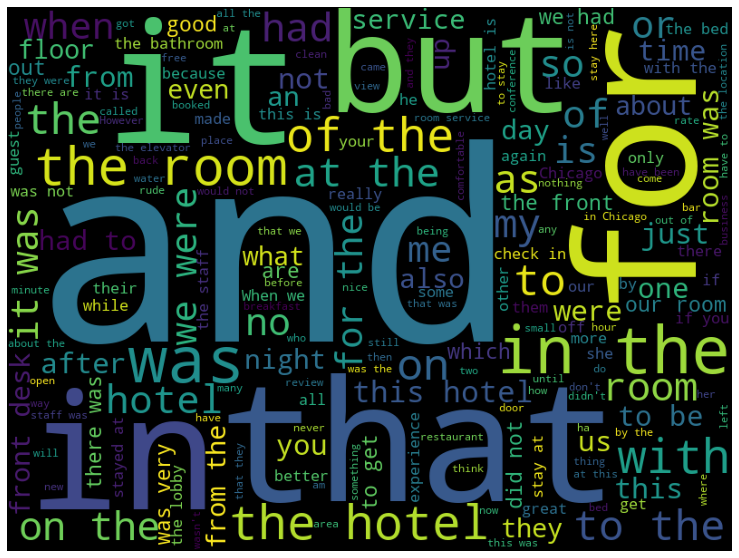

In [ ]:
displayWordCloud(''.join(hotelreview_df.Reviews[400:800]))

Postive Truth

{'and': 1.0, 'for': 0.37043330501274424, 'in': 0.2752761257434155, 'the hotel': 0.25148683092608326, 'with': 0.2497875955819881, 'it': 0.2463891248937978, 'that': 0.22514868309260833, 'in the': 0.22344944774851316, 'The room': 0.22259983007646558, 'at the': 0.21920135938827529, 'of the': 0.20475785896346643, 'and the': 0.19541206457094307, 'but': 0.17757009345794392, 'to': 0.1588785046728972, 'room was': 0.1427357689039932, 'to the': 0.13848768054375532, 'of': 0.13593882752761258, 'is': 0.13338997451146983, 'as': 0.12914188615123195, 'this hotel': 0.12574341546304163, 'on': 0.1231945624468989, 'we': 0.12064570943075616, 'was very': 0.11894647408666101, 'our': 0.11809685641461343, 'all': 0.11469838572642312, 'it was': 0.11469838572642312, 'on the': 0.11469838572642312, 'The staff': 0.11384876805437553, 'had': 0.11129991503823279, 'from the': 0.10620220900594732, 'hotel': 0.10110450297366186, 'great': 0.09600679694137638, 'were': 0.0951571792693288, 'we were': 0.09430756159728122, 'so': 

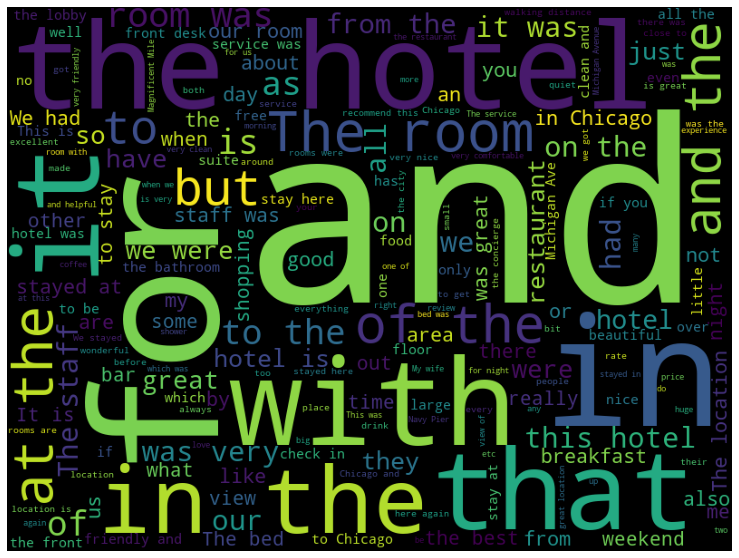

In [ ]:
displayWordCloud(''.join(hotelreview_df.Reviews[800:1200]))

Positive Deceptive

{'and': 1.0, 'with': 0.25503943908851884, 'that': 0.2506573181419807, 'at the': 0.24101665205959685, 'for': 0.23838737949167396, 'the hotel': 0.23049956178790534, 'The room': 0.21384750219106047, 'of the': 0.20946538124452235, 'to': 0.2085889570552147, 'and the': 0.2085889570552147, 'in the': 0.2085889570552147, 'it': 0.1936897458369851, 'this hotel': 0.16739702015775634, 'my': 0.16126205083260298, 'in': 0.16038562664329536, 'we': 0.1446099912357581, 'was': 0.13672217353198948, 'it was': 0.13672217353198948, 'The staff': 0.12795793163891322, 'had': 0.12532865907099036, 'but': 0.12269938650306748, 'in Chicago': 0.1200701139351446, 'as': 0.10692375109553023, 'the': 0.09728308501314636, 'was very': 0.09640666082383874, 'on': 0.09202453987730061, 'i': 0.09027169149868536, 'of': 0.08939526730937773, 'just': 0.08851884312007012, 'stay at': 0.0876424189307625, 'hotel is': 0.08588957055214724, 'all': 0.08413672217353199, 'were': 0.08326029798422437, 'to stay': 0.08150744960560911, 'room was': 

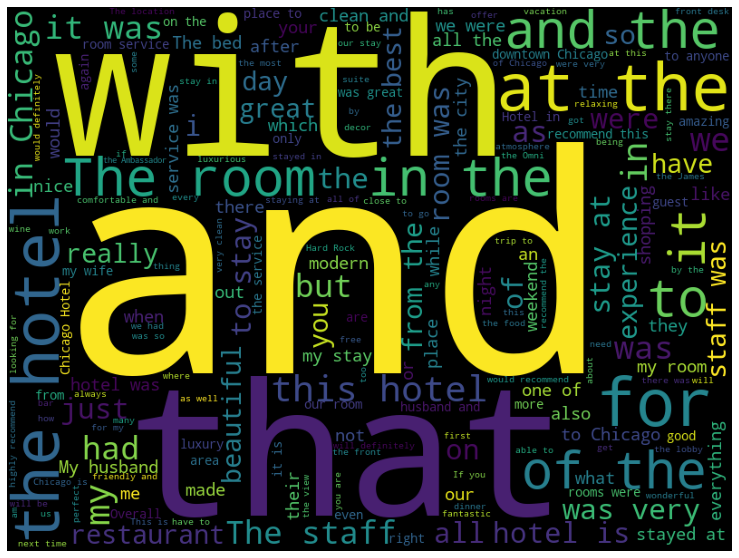

In [ ]:
displayWordCloud(''.join(hotelreview_df.Reviews[1200:1600]))

### N-grams model visualization

N-Grams is a contiguous word of n items from text data.
I visualized each of the text data using a bar chart with the frequencies of 1-gram, 2-grams, and 3-grams in ascending order of 10 each.

In [ ]:
#This is a function that splits text data one word .
def TexttoWords (data = None):
  for char in '-.,\n':
    data=data.replace(char,' ')
    data = data.lower()
  words = data.split()
  return words

Negative Deceptive

In [ ]:
ND_words = TexttoWords(''.join(hotelreview_df.Reviews[0:400]))
ND_1_words = (pd.Series(nltk.ngrams(ND_words, 1)).value_counts())[:10]
ND_2_words = (pd.Series(nltk.ngrams(ND_words, 2)).value_counts())[:10]
ND_3_words = (pd.Series(nltk.ngrams(ND_words, 3)).value_counts())[:10]

This is a bar chart with the frequencies of 1-gram in the Negative Deceptive data.

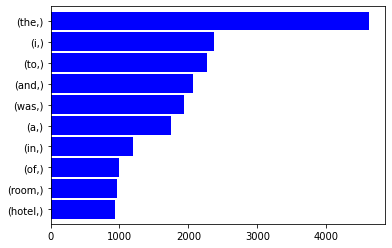

In [ ]:
ND_1_words.sort_values().plot.barh(color='blue', width=.9, figsize=(6, 4))

This is a bar chart with the frequencies of 2-gram in the Negative Deceptive data.

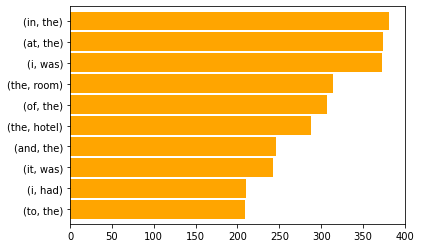

In [ ]:
ND_2_words.sort_values().plot.barh(color='Orange', width=.9, figsize=(6, 4))

This is a bar chart with the frequencies of 3-gram in the Negative Deceptive data.

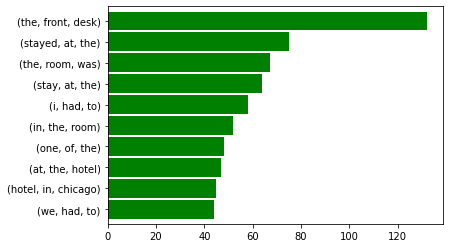

In [ ]:
ND_3_words.sort_values().plot.barh(color='green', width=.9, figsize=(6, 4))

Negative Truth

In [ ]:
NT_words = TexttoWords(''.join(hotelreview_df.Reviews[400:800]))
NT_1_words = (pd.Series(nltk.ngrams(NT_words, 1)).value_counts())[:10]
NT_2_words = (pd.Series(nltk.ngrams(NT_words, 2)).value_counts())[:10]
NT_3_words = (pd.Series(nltk.ngrams(NT_words, 3)).value_counts())[:10]

This is a bar chart with the frequencies of 1-gram in the Negative Truth data.

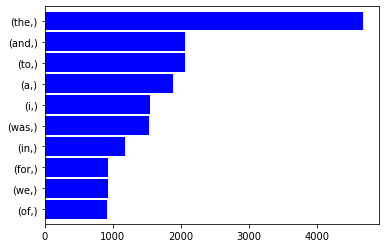

In [ ]:
NT_1_words.sort_values().plot.barh(color='blue', width=.9, figsize=(6, 4))

This is a bar chart with the frequencies of 2-gram in the Negative Truth data.

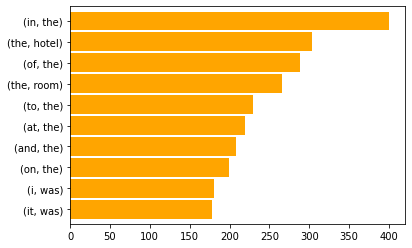

In [ ]:
NT_2_words.sort_values().plot.barh(color='Orange', width=.9, figsize=(6, 4))

This is a bar chart with the frequencies of 3-gram in the Negative Truth data.

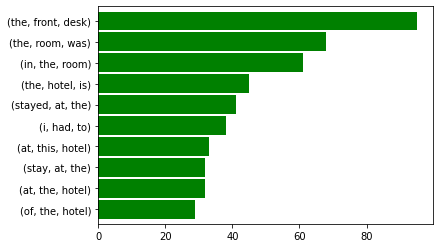

In [ ]:
NT_3_words.sort_values().plot.barh(color='green', width=.9, figsize=(6, 4))

Positive Truth

In [ ]:
PT_words = TexttoWords(''.join(hotelreview_df.Reviews[800:1200]))
PT_1_words = (pd.Series(nltk.ngrams(PT_words, 1)).value_counts())[:10]
PT_2_words = (pd.Series(nltk.ngrams(PT_words, 2)).value_counts())[:10]
PT_3_words = (pd.Series(nltk.ngrams(PT_words, 3)).value_counts())[:10]

This is a bar chart with the frequencies of 1-gram in the Positive Truth data.

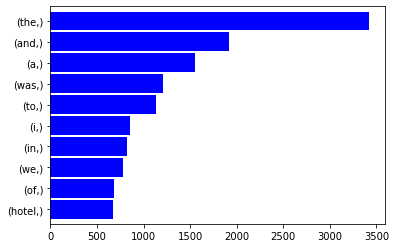

In [ ]:
PT_1_words.sort_values().plot.barh(color='blue', width=.9, figsize=(6, 4))

This is a bar chart with the frequencies of 2-gram in the Positive Truth data.

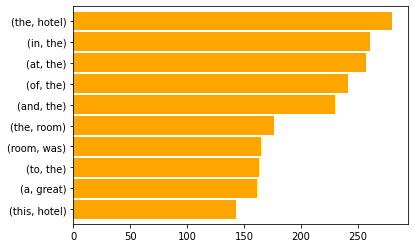

In [ ]:
PT_2_words.sort_values().plot.barh(color='Orange', width=.9, figsize=(6, 4))

This is a bar chart with the frequencies of 3-gram in the Positive Truth data.

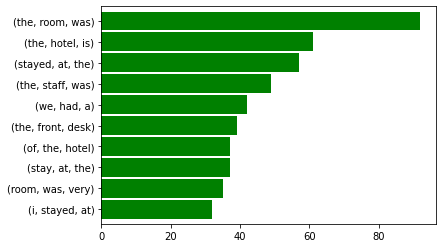

In [ ]:
PT_3_words.sort_values().plot.barh(color='green', width=.9, figsize=(6, 4))

Positive Deceptive

In [ ]:
PD_words = TexttoWords(''.join(hotelreview_df.Reviews[1200:1600]))
PD_1_words = (pd.Series(nltk.ngrams(PD_words, 1)).value_counts())[:10]
PD_2_words = (pd.Series(nltk.ngrams(PD_words, 2)).value_counts())[:10]
PD_3_words = (pd.Series(nltk.ngrams(PD_words, 3)).value_counts())[:10]

This is a bar chart with the frequencies of 1-gram in the Positive Deceptive data.

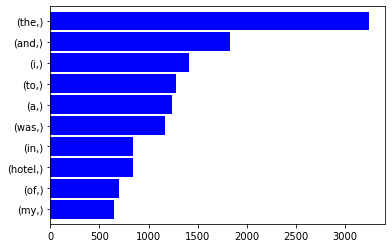

In [ ]:
PD_1_words.sort_values().plot.barh(color='blue', width=.9, figsize=(6, 4))

This is a bar chart with the frequencies of 2-gram in the Positive Deceptive data.

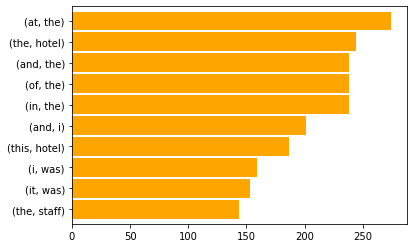

In [ ]:
PD_2_words.sort_values().plot.barh(color='Orange', width=.9, figsize=(6, 4))

This is a bar chart with the frequencies of 3-gram in the Positive Deceptive data.

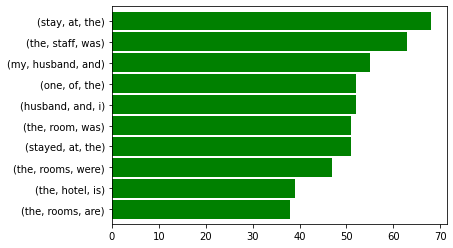

In [ ]:
PD_3_words.sort_values().plot.barh(color='green', width=.9, figsize=(6, 4))

## 4. Pre-process Data : Perform Data Cleaning

Remove non-alphabetic words

In [ ]:
hotelreview_df['CleanedReviews'] = hotelreview_df['Reviews'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

Remove Stopwords

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
new_stop_words = ['i', 'I', 'the', 'The' ' hotel', 'room', 'rooms']
stop_words.extend(new_stop_words)
hotelreview_df['CleanedReviews'] = hotelreview_df['CleanedReviews'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
hotelreview_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Reviews,Polarity,Source,Hotel,Labels,CleanedReviews
0,James Chicago; the luxurious nice hotel as it ...,negative,MTurk,james,deceptive,James luxurious nice hotel want stay wife book...
1,The James Hotel in Chicago looks nice on the w...,negative,MTurk,james,deceptive,James Hotel Chicago looks nice looks employees...
2,I was consistently disappointed throughout my ...,negative,MTurk,james,deceptive,consistently disappointed throughout stay hear...
3,Traveled to this hotel on a family vacation. W...,negative,MTurk,monaco,deceptive,Traveled hotel family chose hotel pet Upon arr...
4,The staff at the James Chicago hotel seemed de...,negative,MTurk,james,deceptive,staff James Chicago hotel seemed determined ma...
...,...,...,...,...,...,...
1595,We stayed for two nights for a meeting. It is ...,positive,MTurk,affinia,deceptive,stayed two nights upscale chain hotel service ...
1596,I enjoyed my stay at the Talbott Hotel. It is ...,positive,MTurk,talbott,deceptive,enjoyed stay Talbott expensive worth got Talbo...
1597,I am writing about my recent stay at the Ambas...,positive,MTurk,ambassador,deceptive,writing recent stay Ambassador East wanted let...
1598,I was visiting relatives in Chicago and wanted...,positive,MTurk,talbott,deceptive,visiting relatives Chicago wanted stay hotel e...


## 5. Result of Cleaned Data

## Bar Chart 
Comparison of the number of words in the original data and the cleaned data

In [ ]:
num_total_word = len(TexttoWords(''.join(hotelreview_df.Reviews)))
num_total_Cleaned_word = len(TexttoWords(''.join(hotelreview_df.CleanedReviews)))
num_total_Deceptive_word = len(TexttoWords(''.join(hotelreview_df.Reviews[0:400])))+len(TexttoWords(''.join(hotelreview_df.Reviews[1200:1600])))
num_total_Truthful_word = len(TexttoWords(''.join(hotelreview_df.Reviews[400:1200])))
num_total_Cleaned_Deceptive_word = len(TexttoWords(''.join(hotelreview_df.CleanedReviews[0:400])))+len(TexttoWords(''.join(hotelreview_df.CleanedReviews[1200:1600])))
num_total_Cleaned_Truthful_word = len(TexttoWords(''.join(hotelreview_df.CleanedReviews[400:1200])))
total_num=pd.DataFrame({'Type':['Total_num','Total_num', 'Deceptive_num', 'Deceptive_num', 'Truthful_num', 'Truthful_num'],
                             'OorC':['Original_Data', 'Cleaned_Data','Original_Data', 'Cleaned_Data','Original_Data', 'Cleaned_Data'],
                             'Num':[num_total_word, num_total_Cleaned_word, num_total_Deceptive_word, num_total_Cleaned_Deceptive_word, num_total_Truthful_word, num_total_Cleaned_Truthful_word]})
total_num

,Type,OorC,Num
0,Total_num,Original_Data,239055
1,Total_num,Cleaned_Data,86712
2,Deceptive_num,Original_Data,117797
3,Deceptive_num,Cleaned_Data,42928
4,Truthful_num,Original_Data,121258
5,Truthful_num,Cleaned_Data,43786


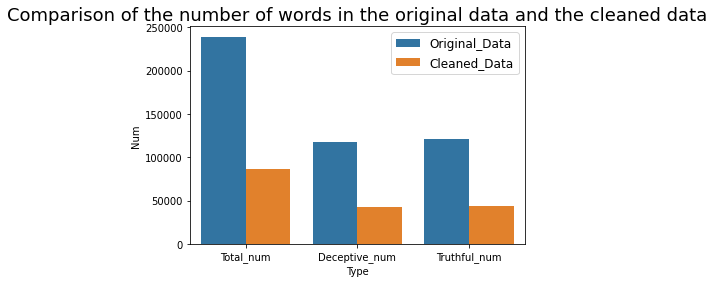

In [ ]:
sns.barplot(x='Type', y='Num', hue='OorC', data=total_num) # default : dodge=True
plt.title('Comparison of the number of words in the original data and the cleaned data', fontsize=18)
plt.legend(fontsize=12)
plt.show()

### Word Cloud

Negative Deceptive

{'hotel': 1.0, 'would': 0.40625, 'stay': 0.37683823529411764, 'one': 0.3327205882352941, 'get': 0.3235294117647059, 'service': 0.32169117647058826, 'could': 0.24632352941176472, 'even': 0.22242647058823528, 'front desk': 0.21507352941176472, 'staff': 0.20588235294117646, 'time': 0.20404411764705882, 'like': 0.20220588235294118, 'first': 0.20220588235294118, 'us': 0.20220588235294118, 'bed': 0.20036764705882354, 'night': 0.19852941176470587, 'got': 0.19669117647058823, 'stayed': 0.19301470588235295, 'check': 0.17830882352941177, 'found': 0.17647058823529413, 'went': 0.17279411764705882, 'experience': 0.16727941176470587, 'arrived': 0.1636029411764706, 'seemed': 0.15441176470588236, 'make': 0.15441176470588236, 'another': 0.14705882352941177, 'made': 0.14338235294117646, 'also': 0.14154411764705882, 'staying': 0.14154411764705882, 'checked': 0.13786764705882354, 'asked': 0.13786764705882354, 'finally': 0.13419117647058823, 'price': 0.1323529411764706, 'much': 0.1323529411764706, 'told': 

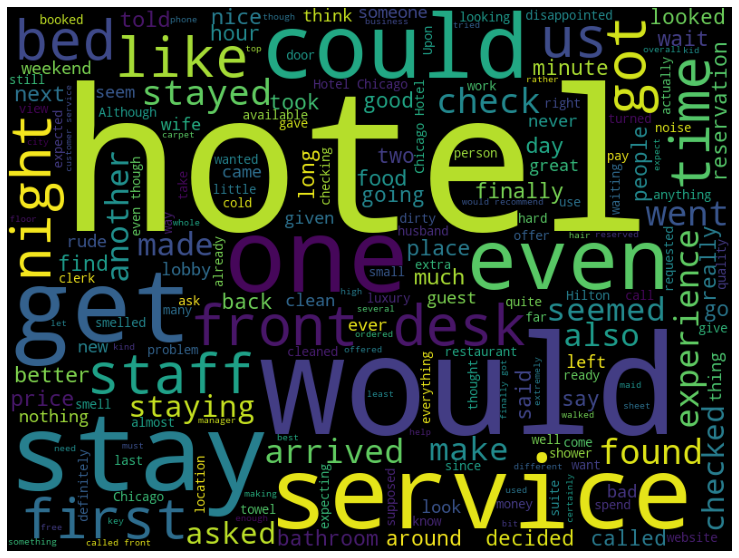

In [ ]:
displayWordCloud(''.join(hotelreview_df.CleanedReviews[0:400]))

Nagative Truth

{'hotel': 1.0, 'would': 0.3481349911190053, 'one': 0.3463587921847247, 'get': 0.33037300177619894, 'stay': 0.2664298401420959, 'service': 0.25932504440497334, 'us': 0.22735346358792186, 'night': 0.22735346358792186, 'even': 0.2202486678507993, 'could': 0.216696269982238, 'staff': 0.216696269982238, 'Chicago': 0.1936056838365897, 'bed': 0.19182948490230906, 'time': 0.19182948490230906, 'called': 0.19005328596802842, 'two': 0.1811722912966252, 'bathroom': 0.17939609236234458, 'got': 0.17406749555950266, 'front desk': 0.17406749555950266, 'nice': 0.17229129662522202, 'like': 0.16518650088809947, 'told': 0.16163410301953818, 'great': 0.15985790408525755, 'day': 0.15985790408525755, 'good': 0.15808170515097691, 'stayed': 0.152753108348135, 'asked': 0.1492007104795737, 'never': 0.14742451154529307, 'also': 0.14209591474245115, 'go': 0.1349911190053286, 'another': 0.13321492007104796, 'floor': 0.13321492007104796, 'check': 0.12966252220248667, 'location': 0.1261101243339254, 'really': 0.12433

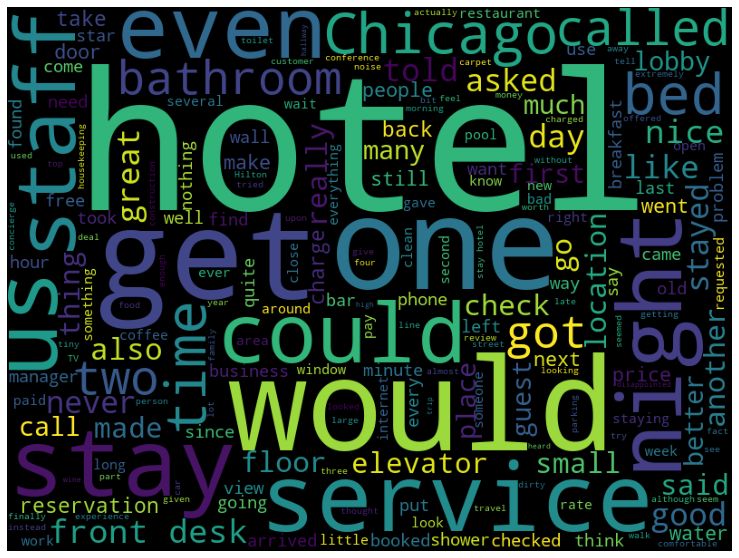

In [ ]:
displayWordCloud(''.join(hotelreview_df.CleanedReviews[400:800]))

Postive Truth

{'hotel': 1.0, 'great': 0.4455252918287938, 'stay': 0.3346303501945525, 'staff': 0.32684824902723736, 'Chicago': 0.301556420233463, 'location': 0.24124513618677043, 'would': 0.2198443579766537, 'stayed': 0.20817120622568094, 'service': 0.20622568093385213, 'nice': 0.20428015564202334, 'good': 0.19066147859922178, 'night': 0.18093385214007782, 'also': 0.17898832684824903, 'us': 0.17898832684824903, 'bed': 0.17120622568093385, 'one': 0.16731517509727625, 'restaurant': 0.1556420233463035, 'get': 0.15369649805447472, 'bathroom': 0.14785992217898833, 'place': 0.14591439688715954, 'like': 0.14396887159533073, 'view': 0.14396887159533073, 'clean': 0.13813229571984437, 'could': 0.13618677042801555, 'got': 0.13424124513618677, 'really': 0.12840466926070038, 'breakfast': 0.1245136186770428, 'day': 0.1245136186770428, 'floor': 0.1245136186770428, 'comfortable': 0.122568093385214, 'large': 0.122568093385214, 'well': 0.11867704280155641, 'friendly': 0.11673151750972763, 'even': 0.11673151750972763,

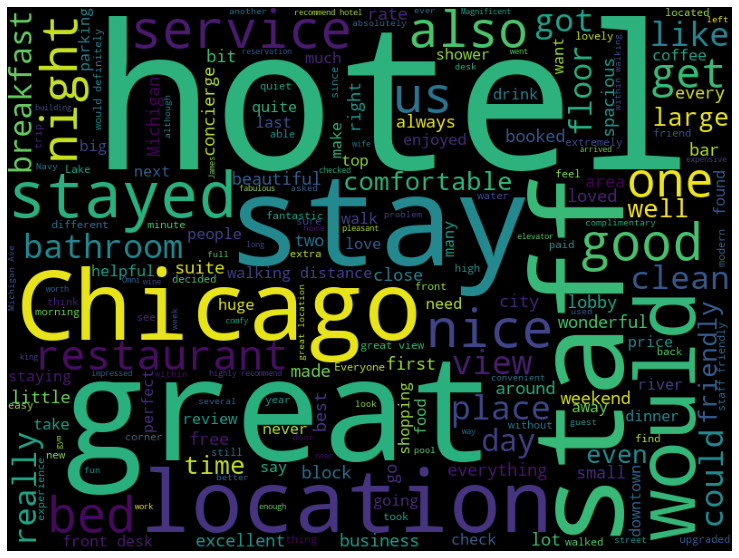

In [ ]:
displayWordCloud(''.join(hotelreview_df.CleanedReviews[800:1200]))

Positive Deceptive

{'hotel': 1.0, 'stay': 0.39879759519038077, 'Chicago': 0.3787575150300601, 'great': 0.3406813627254509, 'staff': 0.3226452905811623, 'service': 0.2605210420841683, 'stayed': 0.23446893787575152, 'one': 0.19438877755511022, 'would': 0.19238476953907815, 'also': 0.18837675350701402, 'nice': 0.17635270541082165, 'like': 0.17034068136272545, 'time': 0.16633266533066132, 'place': 0.16633266533066132, 'bed': 0.1623246492985972, 'business': 0.1623246492985972, 'really': 0.16032064128256512, 'even': 0.15030060120240482, 'could': 0.14228456913827656, 'clean': 0.1402805611222445, 'view': 0.13827655310621242, 'location': 0.13226452905811623, 'get': 0.12625250501002003, 'everything': 0.12224448897795591, 'night': 0.12224448897795591, 'beautiful': 0.12224448897795591, 'restaurant': 0.12024048096192384, 'food': 0.12024048096192384, 'comfortable': 0.12024048096192384, 'city': 0.11623246492985972, 'best': 0.10821643286573146, 'day': 0.10821643286573146, 'well': 0.10821643286573146, 'made': 0.106212424

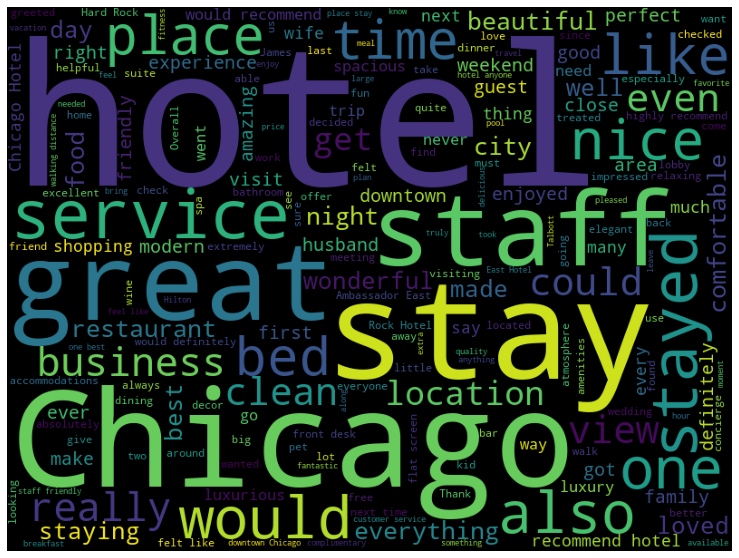

In [ ]:
displayWordCloud(''.join(hotelreview_df.CleanedReviews[1200:1600]))

### N-grams model visualization

Negative Deceptive

In [ ]:
ND_cleaned_words = TexttoWords(''.join(hotelreview_df.CleanedReviews[0:400]))
ND_1_cleaned_words = (pd.Series(nltk.ngrams(ND_cleaned_words, 1)).value_counts())[:10]
ND_2_cleaned_words = (pd.Series(nltk.ngrams(ND_cleaned_words, 2)).value_counts())[:10]
ND_3_cleaned_words = (pd.Series(nltk.ngrams(ND_cleaned_words, 3)).value_counts())[:10]

This is a bar chart with the frequencies of 1-gram in the Negative Deceptive data.

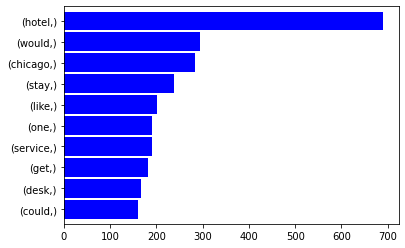

In [ ]:
ND_1_cleaned_words.sort_values().plot.barh(color='blue', width=.9, figsize=(6, 4))

This is a bar chart with the frequencies of 2-gram in the Negative Deceptive data.

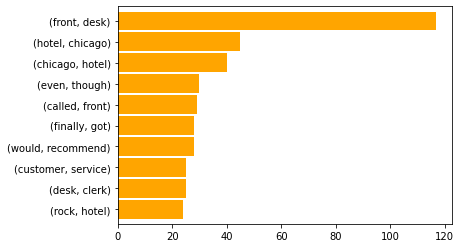

In [ ]:
ND_2_cleaned_words.sort_values().plot.barh(color='Orange', width=.9, figsize=(6, 4))

This is a bar chart with the frequencies of 3-gram in the Negative Deceptive data.

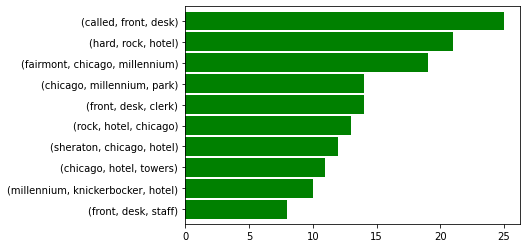

In [ ]:
ND_3_cleaned_words.sort_values().plot.barh(color='green', width=.9, figsize=(6, 4))

Negative Truth

In [ ]:
NT_cleaned_words = TexttoWords(''.join(hotelreview_df.CleanedReviews[400:800]))
NT_1_cleaned_words = (pd.Series(nltk.ngrams(NT_cleaned_words, 1)).value_counts())[:10]
NT_2_cleaned_words = (pd.Series(nltk.ngrams(NT_cleaned_words, 2)).value_counts())[:10]
NT_3_cleaned_words = (pd.Series(nltk.ngrams(NT_cleaned_words, 3)).value_counts())[:10]

This is a bar chart with the frequencies of 1-gram in the Negative Truth data.

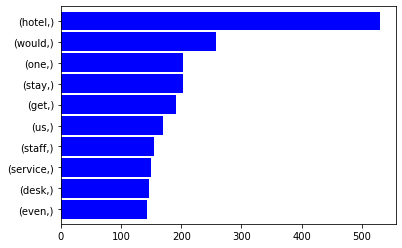

In [ ]:
NT_1_cleaned_words.sort_values().plot.barh(color='blue', width=.9, figsize=(6, 4))

This is a bar chart with the frequencies of 2-gram in the Negative Truth data.

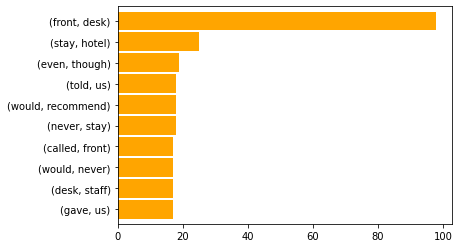

In [ ]:
NT_2_cleaned_words.sort_values().plot.barh(color='Orange', width=.9, figsize=(6, 4))

This is a bar chart with the frequencies of 3-gram in the Negative Truth data.

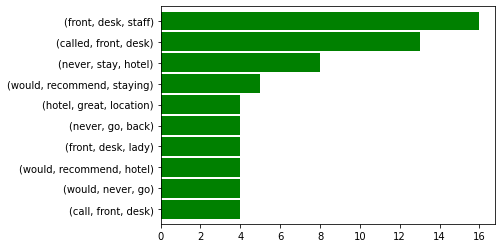

In [ ]:
NT_3_cleaned_words.sort_values().plot.barh(color='green', width=.9, figsize=(6, 4))

Positive Truth

In [ ]:
PT_cleaned_words = TexttoWords(''.join(hotelreview_df.CleanedReviews[800:1200]))
PT_1_cleaned_words = (pd.Series(nltk.ngrams(PT_cleaned_words, 1)).value_counts())[:10]
PT_2_cleaned_words = (pd.Series(nltk.ngrams(PT_cleaned_words, 2)).value_counts())[:10]
PT_3_cleaned_words = (pd.Series(nltk.ngrams(PT_cleaned_words, 3)).value_counts())[:10]

This is a bar chart with the frequencies of 1-gram in the Positive Truth data.

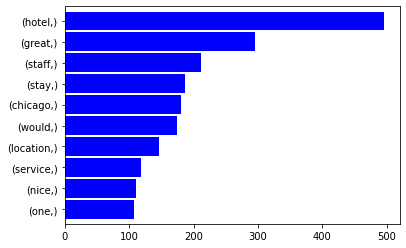

In [ ]:
PT_1_cleaned_words.sort_values().plot.barh(color='blue', width=.9, figsize=(6, 4))

This is a bar chart with the frequencies of 2-gram in the Positive Truth data.

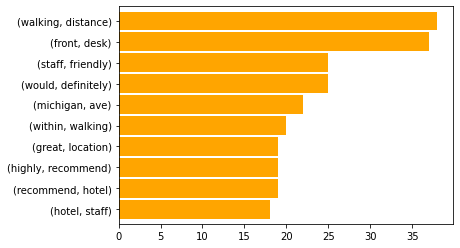

In [ ]:
PT_2_cleaned_words.sort_values().plot.barh(color='Orange', width=.9, figsize=(6, 4))

This is a bar chart with the frequencies of 3-gram in the Positive Truth data.

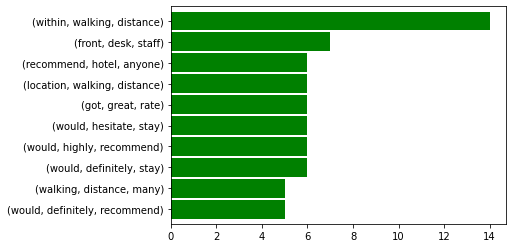

In [ ]:
PT_3_cleaned_words.sort_values().plot.barh(color='green', width=.9, figsize=(6, 4))

Positive Deceptive

In [ ]:
PD_cleaned_words = TexttoWords(''.join(hotelreview_df.CleanedReviews[1200:1600]))
PD_1_cleaned_words = (pd.Series(nltk.ngrams(PD_cleaned_words, 1)).value_counts())[:10]
PD_2_cleaned_words = (pd.Series(nltk.ngrams(PD_cleaned_words, 2)).value_counts())[:10]
PD_3_cleaned_words = (pd.Series(nltk.ngrams(PD_cleaned_words, 3)).value_counts())[:10]

This is a bar chart with the frequencies of 1-gram in the Positive Deceptive data.

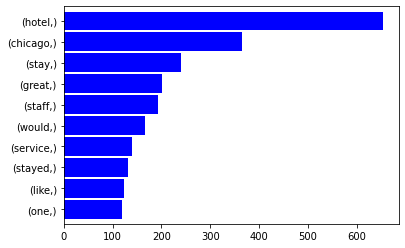

In [ ]:
PD_1_cleaned_words.sort_values().plot.barh(color='blue', width=.9, figsize=(6, 4))

This is a bar chart with the frequencies of 2-gram in the Positive Deceptive data.

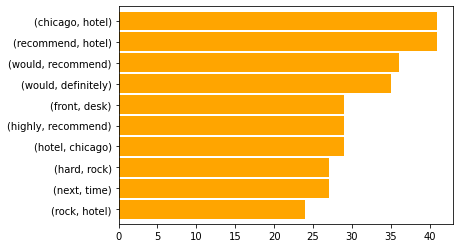

In [ ]:
PD_2_cleaned_words.sort_values().plot.barh(color='Orange', width=.9, figsize=(6, 4))

This is a bar chart with the frequencies of 3-gram in the Positive Deceptive data.

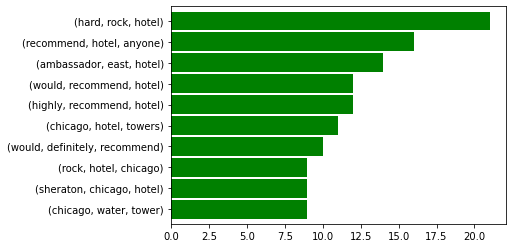

In [ ]:
PD_3_cleaned_words.sort_values().plot.barh(color='green', width=.9, figsize=(6, 4))

## 6. Pre-process Data : Feature Selection & Engineering

Convert the text of the data to numeric values

TfidfVectorizer

TfidfVectorizer is a tool that automatically calculates TF-IDF provided by sklearn. And TF-IDF is a method of weighting the importance of each word in the Document-Term Metrix using word frequency and inverse document frequency.

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(hotelreview_df['CleanedReviews'])
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Label Encoder

Label Encoder is encode target labels with values between 0 and n_classes-1.

In [ ]:
encoder = LabelEncoder()
encoder.fit(hotelreview_df['Labels'])
y = encoder.transform(hotelreview_df['Labels'])
y

array([0, 0, 0, ..., 0, 0, 0])

## 7. Train-Test Split

Split the data into Train (80% of entire data) and Test (20% of entire data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

## 8. Logistic Regression

Training Logistic Regression

In [ ]:
LogisticRegressionmodel = LogisticRegression()
start = time.time()
LogisticRegressionmodel.fit(X_train, y_train)
print("Train Time :", time.time() - start)

Train Time : 0.06492280960083008


Evaluation Metrics

In [ ]:
LogisticRegressionpred = LogisticRegressionmodel.predict(X_test)

print("Train Score:",LogisticRegressionmodel.score(X_train, y_train))
print("Test Score:", LogisticRegressionmodel.score(X_test,y_test))
target_names = ['Deceptive', 'Truthful']
print(classification_report(y_test, LogisticRegressionpred, target_names=target_names)) 

Train Score: 0.96640625
Test Score: 0.853125
              precision    recall  f1-score   support

   Deceptive       0.87      0.83      0.85       157
    Truthful       0.84      0.88      0.86       163

    accuracy                           0.85       320
   macro avg       0.85      0.85      0.85       320
weighted avg       0.85      0.85      0.85       320



Fine Tuning

In [ ]:
C = np.logspace(-4, 4, 50)
param_grid = { 'C': C,
              'max_iter': [20, 50, 100, 200, 500, 1000]}
gcv = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
gcv.fit(X_train, y_train)
print('final params', gcv.best_params_, 'best score', gcv.best_score_)
means = gcv.cv_results_['mean_test_score']
stds = gcv.cv_results_['std_test_score']
params = gcv.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


final params {'C': 1.2067926406393288, 'max_iter': 50} best score 0.85390625
0.502344 (0.001914) with: {'C': 0.0001, 'max_iter': 20}
0.502344 (0.001914) with: {'C': 0.0001, 'max_iter': 50}
0.502344 (0.001914) with: {'C': 0.0001, 'max_iter': 100}
0.502344 (0.001914) with: {'C': 0.0001, 'max_iter': 200}
0.502344 (0.001914) with: {'C': 0.0001, 'max_iter': 500}
0.502344 (0.001914) with: {'C': 0.0001, 'max_iter': 1000}
0.502344 (0.001914) with: {'C': 0.00014563484775012445, 'max_iter': 20}
0.502344 (0.001914) with: {'C': 0.00014563484775012445, 'max_iter': 50}
0.502344 (0.001914) with: {'C': 0.00014563484775012445, 'max_iter': 100}
0.502344 (0.001914) with: {'C': 0.00014563484775012445, 'max_iter': 200}
0.502344 (0.001914) with: {'C': 0.00014563484775012445, 'max_iter': 500}
0.502344 (0.001914) with: {'C': 0.00014563484775012445, 'max_iter': 1000}
0.502344 (0.001914) with: {'C': 0.00021209508879201905, 'max_iter': 20}
0.502344 (0.001914) with: {'C': 0.00021209508879201905, 'max_iter': 50}
0

In [ ]:
TunedLogisticRegressionmodel = LogisticRegression(C=1.2067926406393288, max_iter=50)
start = time.time()
TunedLogisticRegressionmodel.fit(X_train, y_train)
print("Train Time :", time.time() - start)
TunedLogisticRegressionpred = TunedLogisticRegressionmodel.predict(X_test)

print("Train Score:",TunedLogisticRegressionmodel.score(X_train, y_train))
print("Test Score:",TunedLogisticRegressionmodel.score(X_test,y_test))
target_names = ['Deceptive', 'Truthful']
print(classification_report(y_test, TunedLogisticRegressionpred, target_names=target_names)) 

Train Time : 0.18784570693969727
Train Score: 0.96796875
Test Score: 0.853125
              precision    recall  f1-score   support

   Deceptive       0.87      0.83      0.85       157
    Truthful       0.84      0.88      0.86       163

    accuracy                           0.85       320
   macro avg       0.85      0.85      0.85       320
weighted avg       0.85      0.85      0.85       320



## 9. SVM

Training SVM

In [ ]:
SVMmodel = SVC()
start = time.time()
SVMmodel.fit(X_train, y_train) 
print("Train Time :", time.time() - start)

Train Time : 0.9558990001678467


Evaluation Metrics

In [ ]:
SVMpred = SVMmodel.predict(X_test)

print("Train Score:",SVMmodel.score(X_train, y_train))
print("Test Score:", SVMmodel.score(X_test,y_test))
target_names = ['Deceptive', 'Truthful']
print(classification_report(y_test, SVMpred, target_names=target_names)) 

Train Score: 1.0
Test Score: 0.85625
              precision    recall  f1-score   support

   Deceptive       0.87      0.83      0.85       157
    Truthful       0.85      0.88      0.86       163

    accuracy                           0.86       320
   macro avg       0.86      0.86      0.86       320
weighted avg       0.86      0.86      0.86       320



Fine Tuning

In [ ]:
C_SVM = [50, 10, 1.0, 0.1, 0.01]
param_grid_SVM = { 'C': C_SVM,
              'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
gcv_SVM = GridSearchCV(SVC(), param_grid_SVM)
gcv_SVM.fit(X_train, y_train)
print('final params', gcv_SVM.best_params_, 'best score', gcv_SVM.best_score_)
means_SVM = gcv_SVM.cv_results_['mean_test_score']
stds_SVM = gcv_SVM.cv_results_['std_test_score']
params_SVM = gcv_SVM.cv_results_['params']
for mean_SVM, stdev_SVM, param_SVM in zip(means_SVM, stds_SVM, params_SVM):
    print("%f (%f) with: %r" % (mean_SVM, stdev_SVM, param_SVM))

final params {'C': 50, 'kernel': 'rbf'} best score 0.85625
0.840625 (0.014490) with: {'C': 50, 'kernel': 'linear'}
0.821875 (0.038241) with: {'C': 50, 'kernel': 'poly'}
0.856250 (0.018880) with: {'C': 50, 'kernel': 'rbf'}
0.808594 (0.004941) with: {'C': 50, 'kernel': 'sigmoid'}
0.840625 (0.014490) with: {'C': 10, 'kernel': 'linear'}
0.821875 (0.038241) with: {'C': 10, 'kernel': 'poly'}
0.856250 (0.018880) with: {'C': 10, 'kernel': 'rbf'}
0.807813 (0.005182) with: {'C': 10, 'kernel': 'sigmoid'}
0.852344 (0.015309) with: {'C': 1.0, 'kernel': 'linear'}
0.820312 (0.037304) with: {'C': 1.0, 'kernel': 'poly'}
0.852344 (0.016646) with: {'C': 1.0, 'kernel': 'rbf'}
0.853125 (0.015349) with: {'C': 1.0, 'kernel': 'sigmoid'}
0.696875 (0.027688) with: {'C': 0.1, 'kernel': 'linear'}
0.502344 (0.001914) with: {'C': 0.1, 'kernel': 'poly'}
0.502344 (0.001914) with: {'C': 0.1, 'kernel': 'rbf'}
0.682813 (0.024878) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.502344 (0.001914) with: {'C': 0.01, 'kernel': 'line

In [ ]:
TunedSVMmodel = SVC(C=50, kernel='rbf')
start = time.time()
TunedSVMmodel.fit(X_train, y_train)
print("Train Time :", time.time() - start)
TunedSVMpred = TunedSVMmodel.predict(X_test)

print("Train Score:",TunedSVMmodel.score(X_train, y_train))
print("Test Score:",TunedSVMmodel.score(X_test,y_test))
target_names = ['Deceptive', 'Truthful']
print(classification_report(y_test, TunedSVMpred, target_names=target_names)) 

Train Time : 0.9449615478515625
Train Score: 1.0
Test Score: 0.85625
              precision    recall  f1-score   support

   Deceptive       0.87      0.83      0.85       157
    Truthful       0.84      0.88      0.86       163

    accuracy                           0.86       320
   macro avg       0.86      0.86      0.86       320
weighted avg       0.86      0.86      0.86       320



## 10. Random Forest

Training Random Forest

In [ ]:
RandomForestmodel = RandomForestClassifier(n_estimators=10)
start = time.time()
RandomForestmodel.fit(X_train, y_train) 
print("Train Time :", time.time() - start)

Train Time : 0.10791182518005371


Evaluation Metrics

In [ ]:
RandomForestpred = RandomForestmodel.predict(X_test)

print("Train Score:",RandomForestmodel.score(X_train, y_train))
print("Test Score:", RandomForestmodel.score(X_test,y_test))
target_names = ['Deceptive', 'Truthful']
print(classification_report(y_test, RandomForestpred, target_names=target_names)) 

Train Score: 0.9921875
Test Score: 0.721875
              precision    recall  f1-score   support

   Deceptive       0.68      0.83      0.75       157
    Truthful       0.79      0.61      0.69       163

    accuracy                           0.72       320
   macro avg       0.73      0.72      0.72       320
weighted avg       0.74      0.72      0.72       320



Fine Tuning

In [ ]:
param_grid_RandomForest = { 'n_estimators': [10, 20, 50, 100, 500, 1000],
                  'max_features': ['sqrt', 'log2']}
gcv_RandomForest = GridSearchCV(RandomForestClassifier(), param_grid_RandomForest)
gcv_RandomForest.fit(X_train, y_train)
print('final params', gcv_RandomForest.best_params_, 'best score', gcv_RandomForest.best_score_)
means_RandomForest = gcv_RandomForest.cv_results_['mean_test_score']
stds_RandomForest = gcv_RandomForest.cv_results_['std_test_score']
params_RandomForest = gcv_RandomForest.cv_results_['params']
for mean_RandomForest, stdev_RandomForest, param_RandomForest in zip(means_RandomForest, stds_RandomForest, params_RandomForest):
    print("%f (%f) with: %r" % (mean_RandomForest, stdev_RandomForest, param_RandomForest))

final params {'max_features': 'log2', 'n_estimators': 1000} best score 0.853125
0.729688 (0.017712) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.751563 (0.018912) with: {'max_features': 'sqrt', 'n_estimators': 20}
0.816406 (0.031152) with: {'max_features': 'sqrt', 'n_estimators': 50}
0.828906 (0.010305) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.837500 (0.022453) with: {'max_features': 'sqrt', 'n_estimators': 500}
0.839844 (0.014616) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.672656 (0.028853) with: {'max_features': 'log2', 'n_estimators': 10}
0.723437 (0.025603) with: {'max_features': 'log2', 'n_estimators': 20}
0.762500 (0.013396) with: {'max_features': 'log2', 'n_estimators': 50}
0.807031 (0.011213) with: {'max_features': 'log2', 'n_estimators': 100}
0.846094 (0.014106) with: {'max_features': 'log2', 'n_estimators': 500}
0.853125 (0.012742) with: {'max_features': 'log2', 'n_estimators': 1000}


In [ ]:
TunedRandomForestmodel = RandomForestClassifier(n_estimators=1000, max_features='log2')
start = time.time()
TunedRandomForestmodel.fit(X_train, y_train)
print("Train Time :", time.time() - start)
TunedRandomForestpred = TunedRandomForestmodel.predict(X_test)

print("Train Score:",TunedRandomForestmodel.score(X_train, y_train))
print("Test Score:",TunedRandomForestmodel.score(X_test,y_test))
target_names = ['Deceptive', 'Truthful']
print(classification_report(y_test, TunedRandomForestpred, target_names=target_names)) 

Train Time : 7.3720762729644775
Train Score: 1.0
Test Score: 0.828125
              precision    recall  f1-score   support

   Deceptive       0.79      0.88      0.83       157
    Truthful       0.87      0.78      0.82       163

    accuracy                           0.83       320
   macro avg       0.83      0.83      0.83       320
weighted avg       0.83      0.83      0.83       320



## Reference:

How to Design A Spam Filtering System with Machine Learning Algorithms: https://towardsdatascience.com/email-spam-detection-1-2-b0e06a5c0472

Generate word cloud in Python: https://www.geeksforgeeks.org/generating-word-cloud-python/

From DataFrame to N-Grams: https://towardsdatascience.com/from-dataframe-to-n-grams-e34e29df3460

How to Clean Text for Machine Learning with Python: https://machinelearningmastery.com/clean-text-machine-learning-python/

Logistic Regression - Detailed Overview: https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc

Support Vector Machine: https://scikit-learn.org/stable/modules/svm.html

Understanding Random Forest: https://towardsdatascience.com/understanding-random-forest-58381e0602d2

sklearn.linear_model.LogisticRegression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

sklearn.model_selection.GridSearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

sklearn.svm.SVC: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

sklearn.ensemble.RandomForestClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

